# Отток клиентов оператора сотовой связи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## 1. Исследовательский анализ данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings('ignore')

Загрузим датасеты

In [2]:
#contract = pd.read_csv('C://jupyter//final_provider//final_provider//contract.csv')
#personal = pd.read_csv('C://jupyter//final_provider//final_provider//personal.csv')
#internet = pd.read_csv('C://jupyter//final_provider//final_provider//internet.csv')
#phone = pd.read_csv('C://jupyter//final_provider//final_provider//phone.csv')

contract = pd.read_csv("/datasets/final_provider/contract.csv")
internet = pd.read_csv("/datasets/final_provider/internet.csv")
personal = pd.read_csv("/datasets/final_provider/personal.csv")
phone = pd.read_csv("/datasets/final_provider/phone.csv")

#### Таблица "Информация о договоре"

Описание полей данных:

* BeginDate – дата начала пользования услугами,
* EndDate – дата окончания пользования услугами,
* Type – тип оплаты: ежемесячный, годовой и тд,
* PaperlessBilling – безналичный расчет,
* PaymentMethod – способ оплаты,
* MonthlyCharges – ежемесячные траты на услуги,
* TotalCharges – всего потрачено денег на услуги

In [3]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


Данные загружены корректно.

Названия столбцов можно привести к единому стилю CamelCase.

In [4]:
contract.rename(columns={'customerID': 'CustomerID'}, inplace=True)

In [5]:
contract.columns

Index(['CustomerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

Посмотрим базовую информацию

In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропуски в данных отсутствуют.

При этом необходимо заменить тип данных в некоторых столбцах:
* BeginDate -  datetime

* TotalCharges - float

Целевого столбца в явном виде нет, но наличие или отсутствие даты в столбце 'EndDate' явно говорит о том, ушёл клиент или нет. Поэтому в дальнейшем необходимо будет выделить из этого столбца целевой признак.

In [7]:
# Заменим типы данных:

contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

Посмотрим на количество дублей

In [8]:
contract.duplicated().sum()

0

Дубликаты отсутствуют, хорошо. Переходим к следующему датафрейму.

#### Таблица "Персональные данные клиента"

Описание полей данных:

* Gender - пол	
* Dependents – наличие иждивенцев
* Senior Citizen – наличие пенсионного статуса по возрасту
* Partner – наличие супруга(и)

In [9]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


В таблице содержится 7043 объекта исследования и 5 признаков объектов.

Приведём названия столбцов к единому стилю.

In [10]:
personal.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'}, inplace=True)
personal.columns

Index(['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

Посмотрим базовую информацию

In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Типы данных оставляем без измененний.

Посмотрим на количество дубликатов

In [12]:
personal.duplicated().sum()

0

Дубликаты отсутствуют. 

#### Таблица "Информация об интернет-услугах"

In [13]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


В таблице содержится 5517 объектов исследования и 8 признаков объектов.

Приведём названия столбцов к единому стилю.

In [14]:
internet.rename(columns={'customerID': 'CustomerID'}, inplace=True)
internet.columns

Index(['CustomerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

Взглянем на базовую информацию

In [15]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропуски отсутствуют. Все типы данных корректны.

Посмотрим на количество дубликатов

In [16]:
internet.duplicated().sum()

0

Дубликаты отсутствуют. 

#### Таблица "Информация об услугах телефонии"

In [17]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


В таблице содержится 6361 объект исследования и 2 признака объектов.

Приведём названия столбцов к единому стилю.

In [18]:
phone.rename(columns={'customerID': 'CustomerID'}, inplace=True)
phone.columns

Index(['CustomerID', 'MultipleLines'], dtype='object')

Посмотрим на базовую информацию

In [19]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропуски отсутствуют. Все типы данных корректны.

Посмотрим на количество дубликатов

In [20]:
phone.duplicated().sum()

0

Дубликаты отсутствуют. 

#### Вывод:

В процессе исследовательского анализа мы посмотрели все предоставленные таблицы и установили следующее:

* Все таблицы содержат уникальный код клиента `customerID`. В дальнейшем таблицы можно будет объединить в одну по данному признаку.
* Таблицы с информацией об интернет-услугах и услугах телефонии содержат значительно меньше строк, чем таблица с контактами клиентов. Это означает, что не каждый клиент пользуется сразу всеми видами услуг. 
* На основе столбца `EndDate` в дальнейшем необходимо будет сформировать новый столбец с целевым признаком.
* Пропуски в данных не обнаружены.
* Неверные типы данных были заменены.

## 2. Предобработка данных

Объединим все четыре таблицы в одну и далее будем работать со всеми признаками вместе.

In [21]:
df = contract.merge(personal, how='left', on='CustomerID').merge(
                    internet, how='left', on='CustomerID').merge(
                    phone, how='left', on='CustomerID')
df.head(5)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [22]:
df.shape

(7043, 20)

Все данные на месте, ни чего не потерялось. Отлично.

In [23]:
df.CustomerID.nunique()

7043

Все объекты уникальны, дублей нет.

#### Обработаем пропуски

In [24]:
df.isna().sum()

CustomerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Посмотрим на строки с отсутствующим значением `TotalCharges`

In [25]:
df[df['TotalCharges'].isnull()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Дата заключения договора у всех этих клиентов - 01 февраля 2020г. Это крайняя дата записи информации в датафрейм. Возможно данные клиенты ещё не успели внести оплату по договору. Так как их совсем не много (11 объектов), просто удалим данные строки.

In [26]:
df.dropna(subset =['TotalCharges'], inplace = True)
df.shape

(7032, 20)

Пропуски в интернет-услугах и услугах телефонии появились предположительно из-за того, что клиенты данными услугами просто не пользуются. Заменим их на "No".

In [27]:
df = df.fillna('No')

df.isna().sum()

CustomerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Отлично, с пропусками разобрались.

#### Создание целевого признака

Целевой признак создадим на основе столбца `EndDate`. Наличие даты в данном столбце означает что клент потерян. Обозначим признак как `LostCustomer`.

In [28]:
df['LostCustomer'] = df['EndDate'].copy()
df.LostCustomer[df['LostCustomer'] != 'No'] = 1
df.LostCustomer[df['LostCustomer'] == 'No'] = 0

df['LostCustomer'] = pd.to_numeric(df['LostCustomer'])

df.LostCustomer.value_counts()

0    5163
1    1869
Name: LostCustomer, dtype: int64

Создадим дополнительно столбец с общим временем обслуживания клиента в компании. Он будет более информативен, чем даты начальной и конечной регистрации клиента. Обозначим признак как `UsageTime`.

In [29]:
# Заменим все значения "No" на крайнюю дату отчета (01.02.2020).

df['EndDate'] = df['EndDate'].replace('No','2020-02-01')
df['EndDate'] = pd.to_datetime(df['EndDate'])

In [30]:
# Создадим дополнительный столбец с общим временем обслуживания клиента.

df['UsageTime'] = (pd.to_datetime(df['EndDate']) - pd.to_datetime(df['BeginDate'])).dt.days
df['UsageTime'] = df['UsageTime'].astype('int')

Удалим признаки `BeginDate` и `EndDate`, они нам больше не понадобятся.

In [31]:
df.drop(['EndDate', 'BeginDate'], axis='columns', inplace=True)

Так же можно удалить столбец `PaperlessBilling`. Так как запрос чека на оплату услуг абсолютно не влияет на вероятность ухода клиента из компании.

In [32]:
df.drop('PaperlessBilling', axis='columns', inplace=True)

In [33]:
# В заключении предобработки, определим код клиента как индекс нашего датафрейма.

df = df.set_index('CustomerID')

In [34]:
df

,Type,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,LostCustomer,UsageTime
CustomerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,One year,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Month-to-month,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,61
7795-CFOCW,One year,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,Month-to-month,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,Mailed check,84.80,1990.50,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0,730
2234-XADUH,One year,Credit card (automatic),103.20,7362.90,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,2191
4801-JZAZL,Month-to-month,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No,0,337


#### Вывод:

В данном блоке мы провели предобработку данных.
* Объединили все таблицы в одну. 
* Разобрались с пропущенными значениями. 
* Добавили новые признаки `LostCustomer` - наш целевой признак и `UsageTime` - общее время обслуживания клиента в компании.
* Удалены лишние признаки: `BeginDate`, `EndDate` и `PaperlessBilling`.

## 3. Подготовка данных для моделей

#### Разделим наш датасет на `target` и `features`

In [35]:
features = df.drop(['LostCustomer'], axis=1)
target = df['LostCustomer']

print('Размер исходного датафрейма:', df.shape,
      '\nРазмер features:', features.shape,
      '\nРазмер target:', target.shape)

Размер исходного датафрейма: (7032, 18) 
Размер features: (7032, 17) 
Размер target: (7032,)


Создадим список категорийных признаков 

In [36]:
features.nunique()

Type                   3
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
InternetService        3
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
MultipleLines          2
UsageTime            155
dtype: int64

In [37]:
cat_features = features.nunique()[features.nunique() < 5].keys().tolist()
cat_features

['Type',
 'PaymentMethod',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

Кодирование категориальных признаков произведем методом порядкового кодирования OrdinalEncoder

In [38]:
encoder = OrdinalEncoder()
features[cat_features] = encoder.fit_transform(features[cat_features])
features.head()

,Type,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,UsageTime
CustomerID,,,,,,,,,,,,,,,,,
7590-VHVEG,0.0,2.0,29.85,29.85,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,31
5575-GNVDE,1.0,3.0,56.95,1889.50,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1036
3668-QPYBK,0.0,3.0,53.85,108.15,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,61
7795-CFOCW,1.0,0.0,42.30,1840.75,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1371
9237-HQITU,0.0,2.0,70.70,151.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61


#### Проверка корреляции

Выделим количественные признаки

In [39]:
numeric = features.nunique()[features.nunique() > 5].keys().tolist()
numeric

['MonthlyCharges', 'TotalCharges', 'UsageTime']

Построим матрицу количественных признаков

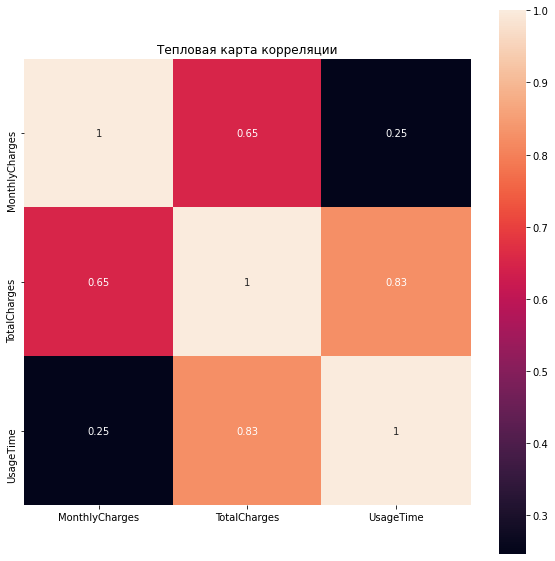

In [40]:
corr_matrix = features[numeric].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, robust=True, square=True, annot=True)

plt.title('Тепловая карта корреляции')
plt.show()

Из матрицы видно, что у нас присутствует проблема мультиколлинеарности. Признаки `TotalCharges` и `UsageTime` имеют сильную корреляцию друг с другом `0,83`. Из-за этого наша будущая модель может переобучиться. Чтобы избежать этого, нужно удалить один из признаков. Удалим `TotalCharges`, так как у него есть высокая корреляция и с признаком `MonthlyCharges`.

In [41]:
features.drop('TotalCharges', axis='columns', inplace=True)

#### Разделим данные на тренировочную, валидационную и тестовую выборки

In [42]:
train_features, valid_test_features, train_target, valid_test_target = train_test_split(
    features, target, test_size=0.4, random_state=42)

valid_features, test_features, valid_target, test_target = train_test_split(
    valid_test_features, valid_test_target, test_size=0.5, random_state=42)

print('Размер обучающей выборки', train_features.shape[0])
print('Размер валидационной выборки', valid_features.shape[0])
print('Размер тестовой выборки', test_features.shape[0])

Размер обучающей выборки 4219
Размер валидационной выборки 1406
Размер тестовой выборки 1407


In [43]:
# Пороверим корректность разделения на выборки

train_features.shape[0] + valid_features.shape[0] + test_features.shape[0]

7032

Так как в данных присутствуют количественные признаки с разными разбросами значений, их нужно масштабировать.\
Приведем данные к одному масштабу методом стандартизации.

In [44]:
numeric = features.nunique()[features.nunique() > 5].keys().tolist()
numeric

['MonthlyCharges', 'UsageTime']

In [45]:
# Чтобы избежать переобучения: обучим стандартизатор на тренировочных данных, а затем стандартизируем всё.

scaler = StandardScaler()
scaler.fit(train_features[numeric])
pd.options.mode.chained_assignment = None
train_features[numeric] = scaler.transform(train_features[numeric])
valid_features[numeric] = scaler.transform(valid_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

In [46]:
train_features.head()

,Type,PaymentMethod,MonthlyCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,UsageTime
CustomerID,,,,,,,,,,,,,,,,
9242-TKFSV,2.0,1.0,0.020409,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.618936
6050-FFXES,2.0,0.0,1.356846,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.500053
4558-FANTW,0.0,2.0,0.908600,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.615793
7798-JVXYM,0.0,2.0,0.171484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,-0.737347
2968-SSGAA,0.0,2.0,1.199130,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,-0.901646


#### Вывод:

Данные подготовлены, корректно поделены на выборки. \
Было произведено кодирование категориальных признаков методом порядкового кодирования OrdinalEncoder. \
Количественные признаки проверили на корреляцию и удалили лишние, чтобы избежать переобучения модели в будущем. \
Количественные признаки, с разными разбросами значений, масштабировали методом стандартизации. \
Можно переходить к следующему этапу.

## 4. Модели машинного обучения

Посмотрим на баланс классов

In [47]:
target.value_counts()

0    5163
1    1869
Name: LostCustomer, dtype: int64

In [48]:
(target[target == 0].count())/(target[target == 1].count())

2.7624398073836276

Объектов отрицательного класса почти в 3 раза больше.

### Логистическая регрессия

Обучим модель логистической регрессии и посмотрим на итоговые метрики

In [49]:
%%time

lr_model = LogisticRegression(random_state=42)
lr_model = lr_model.fit(train_features, train_target)
predict = lr_model.predict(valid_features)

probabilities_valid = lr_model.predict_proba(valid_features)
probabilities_one_valid = probabilities_valid[:, 1]

lr_model_accuracy = accuracy_score(valid_target, predict)
lr_model_roc_auc = roc_auc_score(valid_target, probabilities_one_valid)

print("Accuracy:", lr_model_accuracy.round(3))
print("AUC-ROC:", lr_model_roc_auc.round(3))

Accuracy: 0.789
AUC-ROC: 0.821
CPU times: user 309 ms, sys: 278 ms, total: 587 ms
Wall time: 527 ms


### Случайный лес

Подберём оптимальные параметры модели

In [50]:
# Закомментировал подбор лучших параметров для экономии времени. Найденные параметры указаны ниже.

#%%time

#rfc_model = RandomForestClassifier()

#best_ACC = 0
#best_est = 0
#best_depth = 0
#for est in range(1, 100, 5):
#    for depth in range (1, 20, 5):
#        model = RandomForestClassifier(random_state=42, n_estimators=est ,max_depth=depth)
#        ACC = cross_val_score(rfc_model, train_features, train_target, cv = 3, scoring=make_scorer(accuracy_score))
#        ACC = ACC.mean()
#        if ACC > best_ACC:
#            best_ACC = ACC
#            best_est = est
#            best_depth = depth

#print("Accuracy лучшей модели:", best_ACC.round(3), "\nКоличество деревьев:", best_est, "\nМаксимальная глубина:", depth)

'''
Accuracy лучшей модели: 0.806 
Количество деревьев: 61 
Максимальная глубина: 16
Wall time: 1min 12s
'''

'\nAccuracy лучшей модели: 0.806 \nКоличество деревьев: 61 \nМаксимальная глубина: 16\nWall time: 1min 12s\n'

Протестируем модель с найденными параметрами

In [51]:
%%time

rfc_model = RandomForestClassifier(random_state=42, n_estimators=61, max_depth=16)

rfc_model = rfc_model.fit(train_features, train_target)
predict = rfc_model.predict(valid_features)

probabilities_valid = rfc_model.predict_proba(valid_features)
probabilities_one_valid = probabilities_valid[:, 1]

rfc_accuracy = accuracy_score(valid_target, predict)
rfc_roc_auc = roc_auc_score(valid_target, probabilities_one_valid)

print("Accuracy:", rfc_accuracy.round(3))
print("AUC-ROC:", rfc_roc_auc.round(3))

Accuracy: 0.802
AUC-ROC: 0.83
CPU times: user 279 ms, sys: 7.37 ms, total: 287 ms
Wall time: 285 ms


### CatBoostClassifier

Обучим модель CatBoost и посмотрим на итоговые метрики

In [52]:
%%time

cbc_model = CatBoostClassifier(loss_function="Logloss", verbose=False, random_seed=42,  iterations=300)
cbc_model = cbc_model.fit(train_features, train_target)
predict = cbc_model.predict(valid_features)

probabilities_valid = cbc_model.predict_proba(valid_features)
probabilities_one_valid = probabilities_valid[:, 1]

cbc_accuracy = accuracy_score(valid_target, predict)
cbc_roc_auc = roc_auc_score(valid_target, probabilities_one_valid)

print("Accuracy:", cbc_accuracy.round(3))
print("AUC-ROC:", cbc_roc_auc.round(3))

Accuracy: 0.85
AUC-ROC: 0.891
CPU times: user 683 ms, sys: 55 ms, total: 738 ms
Wall time: 2.14 s


#### Вывод:

Мы попробовали и обучили разные модели. Полученные результаты сведём в общую таблицу.

In [53]:
models = pd.DataFrame({
    'Модель': ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'], 
    'Accuracy': [lr_model_accuracy  , rfc_accuracy  , cbc_accuracy],
    'AUC-ROC': [lr_model_roc_auc, rfc_roc_auc, cbc_roc_auc]

}).set_index('Модель')
models

,Accuracy,AUC-ROC
Модель,,
LogisticRegression,0.789474,0.821407
RandomForestClassifier,0.801565,0.830267
CatBoostClassifier,0.849929,0.890562


Наилучшие предсказания показала модель CatBoostClassifier, **AUC-ROC = 0.89** на валидационных данных.

## 5. Тестирование и проверка адекватности

Протестируем нашу лучшую модель CatBoost. 

In [54]:
cb_preds_test = cbc_model.predict_proba(test_features)
prediction_cb_one_test = cb_preds_test[:, 1]

auc_roc_cb_test = roc_auc_score(test_target, prediction_cb_one_test).round(5)

cb_preds_test_acc = cbc_model.predict(test_features)
accuracy_cb_test = accuracy_score(test_target, cb_preds_test_acc).round(5)

print('AUC-ROC:', auc_roc_cb_test,
      '\nAccuracy:', accuracy_cb_test)

AUC-ROC: 0.89651 
Accuracy: 0.85359


Значение метрик, на тестовых данных, немного увеличилось. Модель удачно прошла тест.

Сравним нашу модель с базисной. В качестве базисной модели возьмем DummyClassifier.

In [55]:
dummy_model = DummyClassifier(random_state=42)
dummy_model.fit(train_features, train_target)
dummy_predict = dummy_model.predict(test_features)

auc_roc_dummy = roc_auc_score(test_target, dummy_predict)
accuracy_dummy = accuracy_score(test_target, dummy_predict)

print('AUC-ROC:', auc_roc_dummy.round(3),
      '\nAccuracy:', accuracy_dummy.round(3))

AUC-ROC: 0.5 
Accuracy: 0.743


Метрики нашей модели значительно выше, чем у базисной модели. Следовательно наша модель адекватна.

#### Важность факторов нашей модели

In [56]:
important_factors = pd.DataFrame(cbc_model.feature_importances_, index = features.columns, columns = ['importance'])
important_factors = important_factors.sort_values(by ='importance', ascending = False).round(1)
important_factors

,importance
UsageTime,47.4
MonthlyCharges,13.2
Type,10.0
InternetService,6.3
PaymentMethod,6.1
Dependents,2.4
Partner,1.8
StreamingTV,1.8
Gender,1.8
MultipleLines,1.8


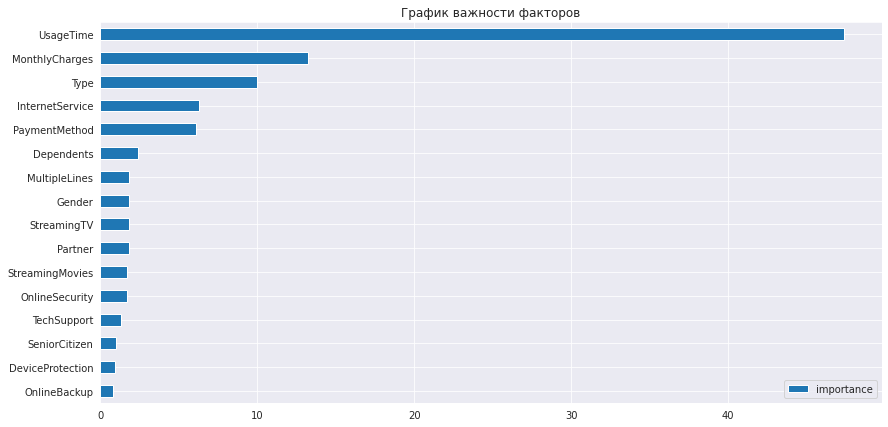

In [57]:
sns.set_style("dark")
important_factors.sort_values(by ='importance', ascending = True).plot(
    kind = 'barh', figsize = (14,7), grid = True, y = 'importance')
plt.title('График важности факторов')
plt.show()

На графике видно, что самые значимые факторы в нашей модели этом: `UsageTime`, `MonthlyCharges`, `Type`, `InternetService` и `PaymentMethod`.

## 6. Общий вывод

В ходе проекта мы проанализировали и подготовили данные телеком кампании. Обучили несколько моделей и выбрали лучшую. Самый высокий результат показала модель **CatBoostClassifier**. Достигнутые значения итоговых метрик на тестовых данных: **AUC-ROC: 0.896**, **Accuracy: 0.853**. \
Модель успешно прошла тестирование и проверку адекватности. По этому мы можем рекомендовать данную модель для прогнозирования оттока клиентов телеком кампании.